# Image Data Collection and Processing

This notebook processes facial images by:
1. Loading images from the `data/images/` directory
2. Applying augmentations to create additional training data
3. Extracting histogram features from each image
4. Saving features to `data/outputs/image_features.csv`


## Step 1: Setup & Imports


In [1]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob


## Step 2: Display Original Images

Let's first load and display sample images to verify they load correctly.


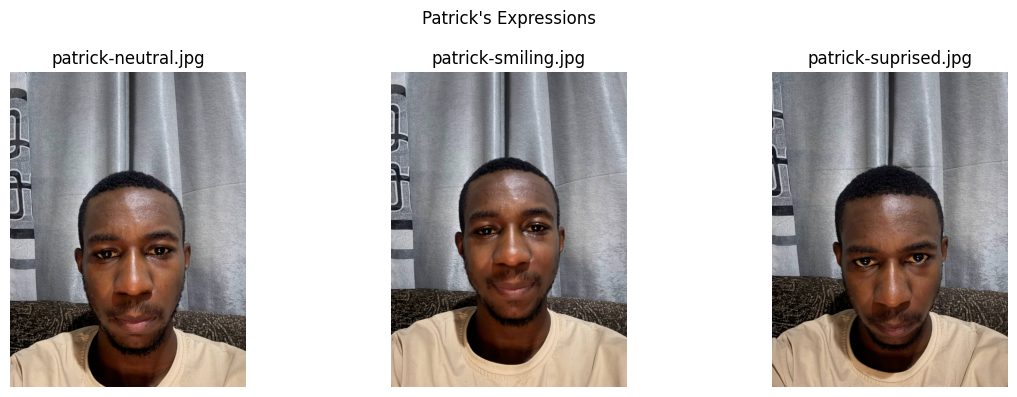

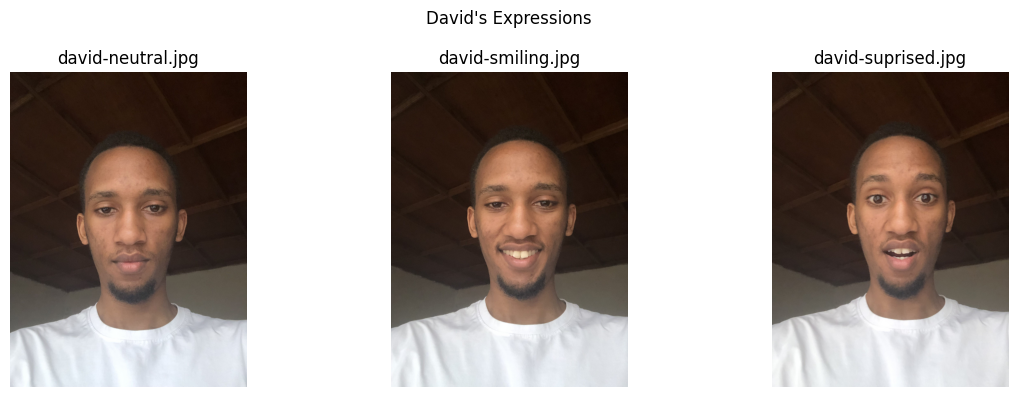

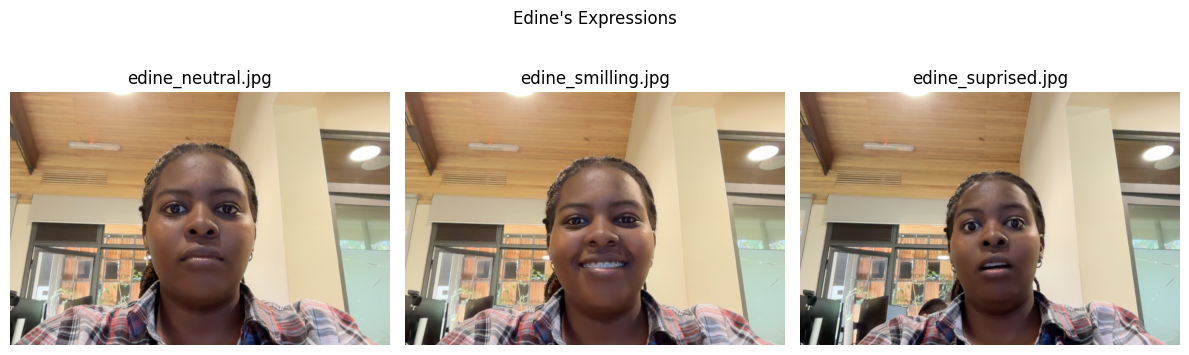

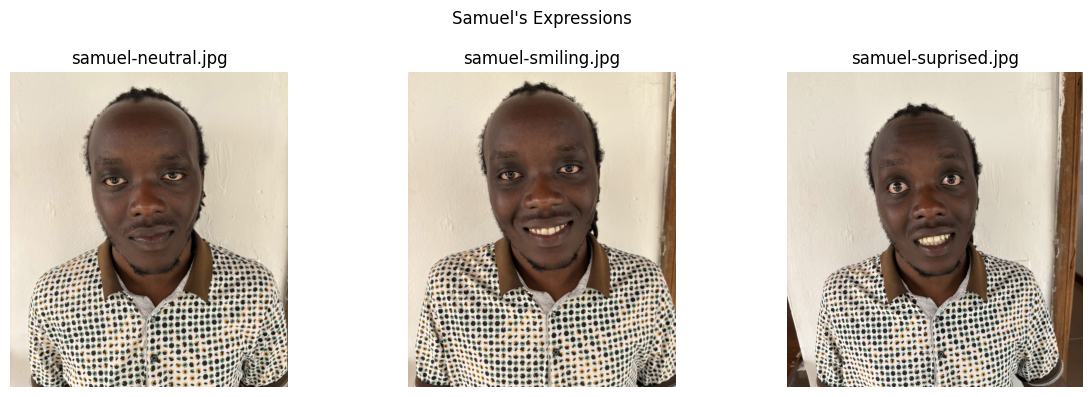

In [ ]:
def load_and_display_images(base_path='../data/images/'):
    """Load and display all images grouped by person."""
    image_files = glob.glob(os.path.join(base_path, '*.jpg'))
    
    
    person_images = {}
    for img_path in image_files:
        filename = os.path.basename(img_path)
        
        person_name = filename.split('-')[0].split('_')[0].capitalize()
        if person_name not in person_images:
            person_images[person_name] = []
        person_images[person_name].append(img_path)
    
   
    for person, images in person_images.items():
        plt.figure(figsize=(12, 4))
        for idx, img_path in enumerate(sorted(images)):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, len(images), idx+1)
            plt.imshow(img)
            plt.title(os.path.basename(img_path))
            plt.axis('off')
        plt.suptitle(f"{person}'s Expressions")
        plt.tight_layout()
        plt.show()

load_and_display_images()


## Step 3: Define Feature Extraction & Augmentation Functions

We'll create functions to:
- Extract histogram features (3D color histogram in HSV space)
- Apply various augmentations (rotation, flipping, brightness, blur, noise, and combinations)


In [ ]:
def extract_histogram(image, bins=(8, 8, 8)):
    """Computes a 3D color histogram from an image."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def rotate_image(image, angle):
    """Rotate image by specified angle."""
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h))

def flip_image(image, direction=1):  
    """Flip image horizontally or vertically."""
    return cv2.flip(image, direction)

def change_brightness(image, value=30):
    """Change image brightness by adding/subtracting value."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v, value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    return cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

def add_gaussian_blur(image):
    """Add Gaussian blur to image."""
    return cv2.GaussianBlur(image, (5, 5), 0)

def add_noise(image):
    """Add Gaussian noise to image."""
    row, col, ch = image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    gauss = gauss.reshape(row, col, ch)
    noisy = image + image * gauss
    return noisy.astype('uint8')


## Step 4: Process All Images and Save to CSV

Now we'll loop through all images, apply augmentations, extract features, and save everything to a CSV file.


In [ ]:
image_folder = '../data/images/'
image_files = glob.glob(os.path.join(image_folder, '*.jpg'))
processed_image_data = []

print(f"Found {len(image_files)} image files to process...\n")

for file_path in image_files:
    try:
        filename = os.path.basename(file_path)
        
        person_name = filename.split('-')[0].split('_')[0].capitalize()
        original_image = cv2.imread(file_path)
        
        if original_image is None:
            print(f"Warning: Could not load {file_path}")
            continue

        
        augmentations = {
            'original': original_image,
            'rotated_pos_10': rotate_image(original_image, 10),
            'rotated_neg_10': rotate_image(original_image, -10),
            'flipped_horizontal': flip_image(original_image, 1),
            'brightness_up': change_brightness(original_image, 50),
            'brightness_down': change_brightness(original_image, -50),
            'blur': add_gaussian_blur(original_image),
            'noise': add_noise(original_image),
            
            'flipped_rotated': rotate_image(flip_image(original_image, 1), 10),
            'flipped_bright': change_brightness(flip_image(original_image, 1), 50),
            'flipped_dark': change_brightness(flip_image(original_image, 1), -50),
            'rotated_bright': change_brightness(rotate_image(original_image, 10), 30),
            'rotated_dark': change_brightness(rotate_image(original_image, -10), -30),
            'blur_bright': change_brightness(add_gaussian_blur(original_image), 30),
            'noise_dark': change_brightness(add_noise(original_image), -30),
        }

       
        for aug_type, aug_image in augmentations.items():
            hist_features = extract_histogram(aug_image)
            processed_image_data.append([person_name, *hist_features, aug_type])
        
        print(f"✅ Processed {filename} - created {len(augmentations)} augmented versions")

    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")


hist_size = 8 * 8 * 8  
columns = ['person'] + [f'hist_{i}' for i in range(hist_size)] + ['augmentation_type']
image_features_df = pd.DataFrame(processed_image_data, columns=columns)


output_dir = '../data/outputs/'
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, 'image_features.csv')
image_features_df.to_csv(output_path, index=False)

print(f"\n{'='*60}")
print(f"✅ Successfully processed {len(image_files)} original images.")
print(f"✅ DataFrame created with {len(image_features_df)} total samples.")
print(f"✅ Saved features to {output_path}")
print(f"✅ Shape of DataFrame: {image_features_df.shape}")
print(f"{'='*60}")


Found 12 image files to process...

✅ Processed patrick-smiling.jpg - created 15 augmented versions
✅ Processed david-suprised.jpg - created 15 augmented versions
✅ Processed edine_smilling.jpg - created 15 augmented versions
✅ Processed patrick-neutral.jpg - created 15 augmented versions
✅ Processed samuel-neutral.jpg - created 15 augmented versions
✅ Processed david-smiling.jpg - created 15 augmented versions
✅ Processed samuel-suprised.jpg - created 15 augmented versions
✅ Processed edine_suprised.jpg - created 15 augmented versions
✅ Processed edine_neutral.jpg - created 15 augmented versions
✅ Processed patrick-suprised.jpg - created 15 augmented versions
✅ Processed david-neutral.jpg - created 15 augmented versions
✅ Processed samuel-smiling.jpg - created 15 augmented versions

✅ Successfully processed 12 original images.
✅ DataFrame created with 180 total samples.
✅ Saved features to ../data/outputs/image_features.csv
✅ Shape of DataFrame: (180, 514)


## Step 5: Preview the Feature Dataset

Let's take a look at the first few rows and some statistics about our dataset.


In [ ]:

print("First 5 rows:")
print(image_features_df.head())

print("\n" + "="*60)
print("Last 5 rows:")
print(image_features_df.tail())

print("\n" + "="*60)
print("Dataset Statistics:")
print(f"Total samples: {len(image_features_df)}")
print(f"Number of features: {hist_size}")
print(f"\nPersons in dataset:")
print(image_features_df['person'].value_counts())
print(f"\nAugmentation types:")
print(image_features_df['augmentation_type'].value_counts())


First 5 rows:
    person    hist_0    hist_1    hist_2    hist_3    hist_4    hist_5  \
0  Patrick  0.019285  0.002189  0.004417  0.012360  0.025055  0.025719   
1  Patrick  0.387056  0.002089  0.003519  0.011291  0.024288  0.026727   
2  Patrick  0.390197  0.001978  0.003492  0.011547  0.025062  0.027069   
3  Patrick  0.019285  0.002189  0.004417  0.012360  0.025055  0.025719   
4  Patrick  0.000000  0.016604  0.001646  0.002385  0.005899  0.016295   

     hist_6    hist_7    hist_8  ...  hist_503  hist_504  hist_505  hist_506  \
0  0.007777  0.000319  0.001765  ...       0.0  0.006110  0.000081  0.000000   
1  0.006154  0.000275  0.001980  ...       0.0  0.005871  0.000068  0.000000   
2  0.006333  0.000280  0.001658  ...       0.0  0.005551  0.000077  0.000000   
3  0.007777  0.000319  0.001765  ...       0.0  0.006110  0.000081  0.000000   
4  0.024846  0.019269  0.000000  ...       0.0  0.000000  0.004910  0.000688   

       hist_507  hist_508  hist_509  hist_510  hist_511   au